In [1]:
from model import UNET
from utils import load_checkpoint
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
from PIL import Image

In [2]:
def display_images_in_row(images):
    fig, axis = plt.subplots(1, len(images), figsize=(9, 3))
    for ax, img in zip(axis, images):
        ax.imshow(img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

def read_images(dir_path):
    images = []
    for image_name in os.listdir(dir_path):
        img_path = os.path.join(dir_path, image_name)
        image = torch.Tensor(np.array((Image.open(img_path).convert("L").resize((960, 960))))).to("cuda")
        image = image.unsqueeze(0)
        images.append(image)
    return images

In [3]:
val_images = read_images("data/val_images")
train_images = read_images("data/train_images")
train_masks = read_images("data/train_masks")

In [4]:
model = UNET(in_channels=1, out_channels=1).to("cuda")
load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

=> Loading checkpoint


In [5]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params / 1e6}M")

Number of parameters: 1.093165M


c:\Users\Opina\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


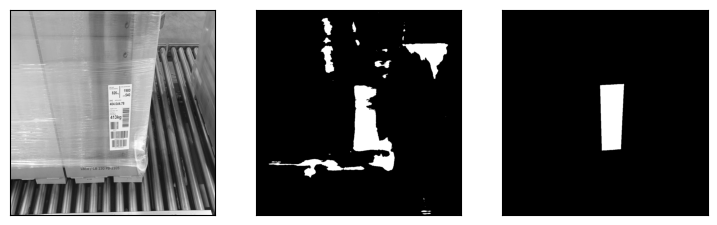

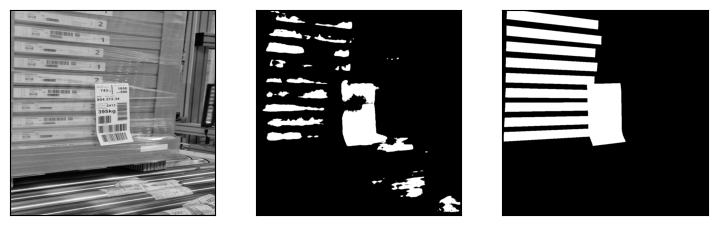

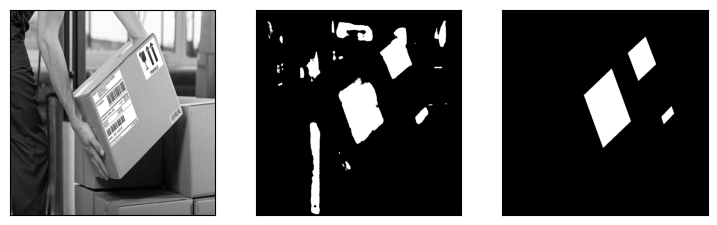

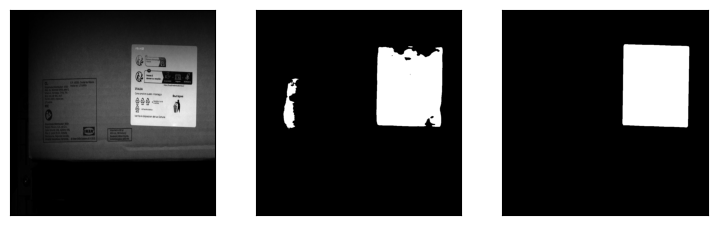

In [6]:
def test_unet(idx):
    result = model.forward(train_images[idx].unsqueeze(0))
    display_images_in_row((
        train_images[idx].cpu().squeeze(0).detach(),
        np.where(np.transpose(np.array(result.to("cpu").detach())[0], (1, 2, 0)) > 0.8, 1, 0),
        train_masks[idx].cpu().squeeze(0).detach()
    ))

test_unet(1)
test_unet(10)
test_unet(16)
test_unet(100)

### Exporting

In [18]:
traced_script_module = torch.jit.trace(model, train_images[0].unsqueeze(0))

In [20]:
model = torch.load("unet_exported.torchscript")
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params / 1e6}M")

Number of parameters: 1.093165M


In [19]:
traced_script_module.save("unet_exported.torchscript")